### 프로젝트 : 다양한 OCR모델 비교하기

우리는 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았습니다.

지금까지 살펴본 바로는 무료로 사용할 수 있는 기능들이지만 모두 준수한 성능을 갖추고 있었습니다. OCR 분야가 이미 실용적인 수준에까지 기술이 발전했기 때문에 이런 것들만 잘 활용해도 실전에 활용할 수 있는 좋은 서비스를 만들어 낼 수 있을것도 같습니다. 그런데 과연 어떤 것을 사용하는 것이 좋을까요?

OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아닙니다. 용도에 맞게 적절한 것을 선택하는 것도 중요한 일입니다. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다. 여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.


### Step1. 검증용 데이터셋 준비

OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.

가능하다면 함께 학습하는 동료들과 힘을 합쳐보는 것을 추천합니다. 그렇다고 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.


In [21]:
import os
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

# keras_ocr
import keras_ocr

# 테서랙트
import pytesseract
from pytesseract import Output

In [22]:
tar_path = os.path.join(os.getenv("HOME"), 'aiffel', 'ocr_python', 'image')
tar_path

'/home/aiffel0042/aiffel/ocr_python/image'

In [23]:
img_paths = glob(tar_path+'/*')
img_paths

['/home/aiffel0042/aiffel/ocr_python/image/253E4237571E2A5123.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/image/amwayon_homecafe_20190924_03.jpg',
 '/home/aiffel0042/aiffel/ocr_python/image/bae7349e156d944fdfbfce53c0bd7688.jpg',
 '/home/aiffel0042/aiffel/ocr_python/image/622f0fd7e078020e733aa8b1b71f7709.png',
 '/home/aiffel0042/aiffel/ocr_python/image/amwayon_homecafe_20190924_02.jpg',
 '/home/aiffel0042/aiffel/ocr_python/image/amwayon_homecafe_20190924_06.jpg',
 '/home/aiffel0042/aiffel/ocr_python/image/c05e62f1416129a3e8ed3b79b8dd0cdd.png',
 '/home/aiffel0042/aiffel/ocr_python/image/13cda70620497db6bc2121ac6414cb26.png',
 '/home/aiffel0042/aiffel/ocr_python/image/cffa9402b3534476830e9b7b7e545764.png',
 '/home/aiffel0042/aiffel/ocr_python/image/a_recipe_1.jpg',
 '/home/aiffel0042/aiffel/ocr_python/image/7d66208a8a3c2bda9f86d4ea429fe6dd.png',
 '/home/aiffel0042/aiffel/ocr_python/image/food-social-media-post-template_104237-71.jpg',
 '/home/aiffel0042/aiffel/ocr_python/image/fe00fcee451

In [24]:
# 데이터 경로 저장
print(len(img_paths[:]))
img_paths = img_paths[:]

20


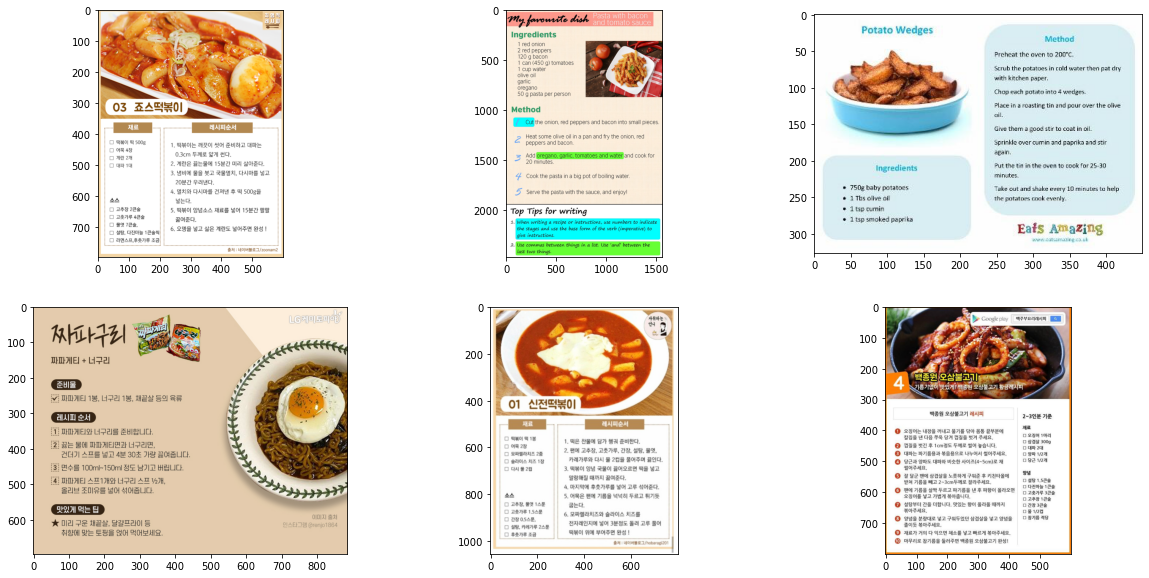

In [25]:
plt.figure(figsize=(20, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    pil_img = Image.open(img_paths[np.random.randint(len(img_paths))])
    plt.imshow(pil_img)
plt.show()

### Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행
위 3가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다.

### (1) Google Cloud Vision API

In [26]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [27]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

# 입력 이미지 경로를 지정해 주세요.
# 20개의 모든 이미지는 너무 많기 때문에 랜덤하게 5개의 사진만 진행
for i in range(5):
    print(f'{i+1}번째 이미지\n')
    detect_text(img_paths[np.random.randint(len(img_paths))])
    print("-"*20+'\n\n')

-rw-r--r-- 1 aiffel0042 aiffel0042 2352 10월 13 08:20 /home/aiffel0042/aiffel/ocr_python/my_google_api_key.json
1번째 이미지

Texts:

"치명적
레시피
03 죠스떡볶이
재료
레시피순서
떡볶이 떡 500g
어묵 4장
계란 2개
1. 떡볶이는 깨끗이 씻어 준비하고 대파는
0.3cm 두께로 얇게 썬다.
2. 계란은 끓는물에 15분간 미리 삶아준다.
대파 1대
3. 냄비에 물을 붓고 국물멸치, 다시마를 넣고
20분간 우려낸다.
4. 멸치와 다시마를 건져낸 후 떡 500g을
소스
넣는다.
□ 고추장 2큰술
□ 고춧가루 4큰술
□ 물엿 7큰술,
□ 설탕, 다진마늘 1큰술씩:
라면스프,후춧가루 조금:
5. 떡볶이 양념소스 재료를 넣어 15분간 팔팔
끓여준다.
6. 오뎅을 넣고 삶은 계란도 넣어주면 완성 !
출처: 네이버블로그/zoonam2
"

"치명적"

"레시피"

"03"

"죠스"

"떡볶이"

"재료"

"레시피"

"순서"

"떡볶이"

"떡"

"500g"

"어묵"

"4"

"장"

"계란"

"2"

"개"

"1."

"떡볶이"

"는"

"깨끗이"

"씻어"

"준비"

"하고"

"대파"

"는"

"0.3cm"

"두께"

"로"

"얇게"

"썬다"

"."

"2."

"계란"

"은"

"끓는"

"물"

"에"

"15"

"분간"

"미리"

"삶아"

"준다"

"."

"대파"

"1"

"대"

"3."

"냄비"

"에"

"물"

"을"

"붓고"

"국물"

"멸치"

","

"다시마"

"를"

"넣고"

"20"

"분간"

"우려"

"낸다"

"."

"4."

"멸치"

"와"

"다시마"

"를"

"건져낸"

"후"

"떡"

"500g"

"을"

"소스"

"넣는다"

"."

"□"

"고추장"

"2"

"큰술"

"□"

"고춧가루"

"4"

"큰술"

"□"

"물엿"

"7"

"큰술"

","

"□"

"

### (2) keras-ocr

In [28]:
!pip install keras-ocr

In [29]:
!echo "export TF_FORCE_GPU_ALLOW_GROWTH=true" >> ~/.bashrc

In [30]:
!echo $TF_FORCE_GPU_ALLOW_GROWTH

true


In [31]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel0042/.keras-ocr/craft_mlt_25k.h5
Looking for /home/aiffel0042/.keras-ocr/crnn_kurapan.h5


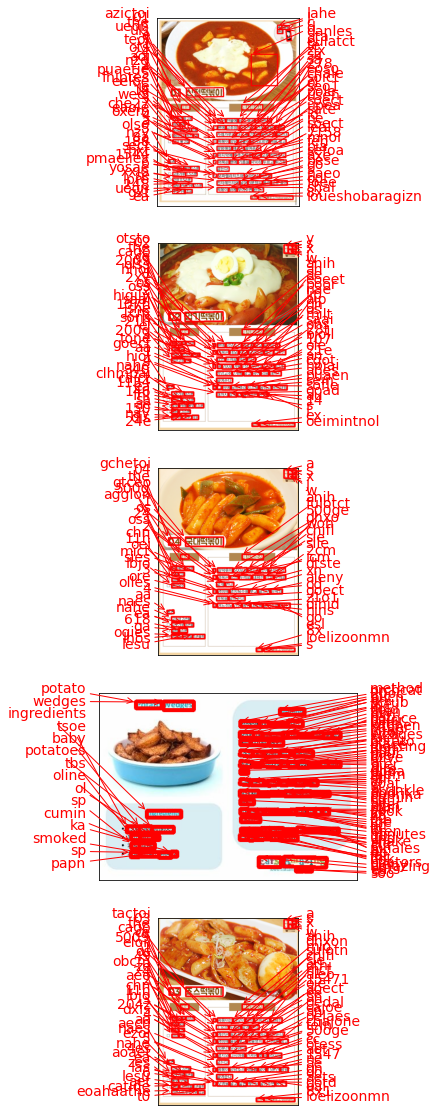

In [32]:
random_idx = np.random.choice(np.arange(len(img_paths)), 5)

image_paths = []
for i in random_idx :
    image_paths.append(img_paths[i])

images = [ keras_ocr.tools.read(path) for path in image_paths]
prediction_groups = [pipeline.recognize([path]) for path in image_paths]

fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### (3) Tesseract

In [33]:
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
#             print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [34]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
# img_file_path = work_dir + '/images/13.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 
cropped_image_path_list = []
for i in range(len(image_paths)) :
    img_file_path = image_paths[i]
    if not os.path.exists(os.path.join(work_dir, f'result_{i}')) :
        os.makedirs(os.path.join(work_dir, f'result_{i}'))
    
    tmp = crop_word_regions(img_file_path, os.path.join(work_dir, f'result_{i}'))
    print(f'{i+1}번째 이미지 완료')
    cropped_image_path_list.extend(tmp)

1번째 이미지 완료
2번째 이미지 완료
3번째 이미지 완료
4번째 이미지 완료
5번째 이미지 완료


In [35]:
cropped_image_path_list

['/home/aiffel0042/aiffel/ocr_python/result_0/0000.png',
 '/home/aiffel0042/aiffel/ocr_python/result_0/0001.png',
 '/home/aiffel0042/aiffel/ocr_python/result_0/0002.png',
 '/home/aiffel0042/aiffel/ocr_python/result_0/0003.png',
 '/home/aiffel0042/aiffel/ocr_python/result_0/0004.png',
 '/home/aiffel0042/aiffel/ocr_python/result_0/0005.png',
 '/home/aiffel0042/aiffel/ocr_python/result_0/0006.png',
 '/home/aiffel0042/aiffel/ocr_python/result_0/0007.png',
 '/home/aiffel0042/aiffel/ocr_python/result_0/0008.png',
 '/home/aiffel0042/aiffel/ocr_python/result_0/0009.png',
 '/home/aiffel0042/aiffel/ocr_python/result_0/0010.png',
 '/home/aiffel0042/aiffel/ocr_python/result_0/0011.png',
 '/home/aiffel0042/aiffel/ocr_python/result_0/0012.png',
 '/home/aiffel0042/aiffel/ocr_python/result_0/0013.png',
 '/home/aiffel0042/aiffel/ocr_python/result_0/0014.png',
 '/home/aiffel0042/aiffel/ocr_python/result_0/0015.png',
 '/home/aiffel0042/aiffel/ocr_python/result_0/0016.png',
 '/home/aiffel0042/aiffel/ocr_p

### 잘린 이미지 단어 인식하기

In [36]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [37]:
random_idx = np.random.choice(np.arange(len(cropped_image_path_list)), 5, replace=False)

# cropped_image_path_list 에서 랜덤하게 선택해서 copped_image_paths에 저장

cropped_image_pahts = []
for idx in random_idx:
    cropped_image_pahts.append(cropped_image_path_list[idx])
cropped_image_pahts

['/home/aiffel0042/aiffel/ocr_python/result_3/0073.png',
 '/home/aiffel0042/aiffel/ocr_python/result_3/0001.png',
 '/home/aiffel0042/aiffel/ocr_python/result_3/0026.png',
 '/home/aiffel0042/aiffel/ocr_python/result_4/0127.png',
 '/home/aiffel0042/aiffel/ocr_python/result_1/0013.png']

In [38]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_pahts)

-36쓴 < 겨더더 녹

\4,4_6ㄷ0265

10

들

1 드

Done


-36쓴 < 겨더더 녹

Done


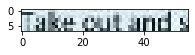

\4,4_6ㄷ0265

Done


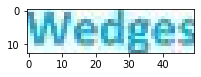

10

Done


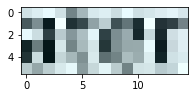

들

Done


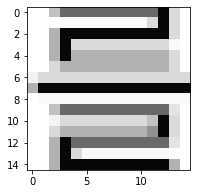

1 드

Done


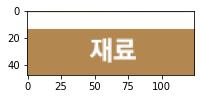

In [39]:
for i in range(5) :
    plt.figure(figsize = (3, 3))
    pil_img = Image.open(cropped_image_pahts[i])
    recognize_images([cropped_image_pahts[i]])
    plt.imshow(pil_img)
    plt.show()

### Step3. 테스트 결과 정리

모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. 시각화 방법이 함께 활용된다면 더욱 좋겠군요.

### (1) Google Cloud Vision API

![구글 클라우드 비전 API 결과](Google.png)

### (2) Keras-ocr

![Keras-OCR 결과](Keras.png)

### (3) Tesseract

![Tesseract](Tesseract.png)

### Step4. 결과 분석과 결론 제시

우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다.
여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가기준을 제시합니다.
그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

### (1) Google Cloud Vision API : 한글 인식이 잘 됩니다.
### (2) Keras-ocr : 개별 글자 인식은 잘 되는데 한글 인식이 안 됩니다. 
### (3) Tesseract : 단어 단위로 조각되어 보여주는데, 원하는 수준으로 인식이 되지 않습니다. 